In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Flatten,Attention, Concatenate, Input ,Reshape
from tensorflow.keras.optimizers import Adam,RMSprop
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,mean_absolute_error,precision_score
import numpy as np
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import backend as K



In [2]:
file_path = r"../data_2/dataset.csv"
df = pd.read_csv(file_path)

In [3]:
df.head()

,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9
0,0.184,106401.5980,103157.1785,1293.4311,592,1150,0.7705,0.2313,0.018043
1,0.184,106399.9771,103155.4379,1293.4311,592,1150,0.7705,0.2313,0.018043
2,0.184,106399.9771,103155.4379,1293.4311,592,1150,0.7705,0.2313,0.000000
3,0.184,106400.7710,103156.2771,1293.4311,592,1150,0.7705,0.2313,0.008414
4,0.184,106402.8029,103158.1105,1293.4311,592,1150,0.7705,0.2313,0.008564


In [4]:
df.drop(['Feature9'],axis=1,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Feature1  300 non-null    float64
 1   Feature2  300 non-null    float64
 2   Feature3  300 non-null    float64
 3   Feature4  300 non-null    float64
 4   Feature5  300 non-null    int64  
 5   Feature6  300 non-null    int64  
 6   Feature7  300 non-null    float64
 7   Feature8  300 non-null    float64
dtypes: float64(6), int64(2)
memory usage: 18.9 KB


In [5]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Standardize the data
data = scaler.fit_transform(df)

In [6]:
time_steps = 8  # 8 rows (1 year)
future_steps = 40  # Predicting 40 rows (5 years)
X, Y = [], []

# Stop at a safe index to prevent out-of-bounds errors
for i in range(len(data) - time_steps - future_steps + 1):
    X.append(data[i:i + time_steps])          # Past 8 rows
    Y.append(data[i + time_steps: i + time_steps + future_steps])  # Next 40 rows

X, Y = np.array(X), np.array(Y)  

print(f" Dataset shape: X={X.shape}, Y={Y.shape}")  # (252, 8, 8) and (252, 40, 8)

 Dataset shape: X=(253, 8, 8), Y=(253, 40, 8)


In [7]:
X, Y = np.array(X), np.array(Y)
print("Shape of X:", X.shape)  # (samples, time_steps, features)
print("Shape of Y:", Y.shape)  # (samples, features)

Shape of X: (253, 8, 8)
Shape of Y: (253, 40, 8)


In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Dense, Attention, Conv1D, Flatten,MultiHeadAttention
from tensorflow.keras.models import Model


def create_custom_rnn(input_shape, output_steps, num_features):
    inputs = Input(shape=input_shape)
    
    # Attention Layer
    attention = MultiHeadAttention(num_heads=4, key_dim=8)(inputs, inputs)
    
    # Temporal Convolutional Layer
    conv = Conv1D(filters=32, kernel_size=4, dilation_rate=2, activation='relu')(attention)
    
    # LSTM Layer
    lstm = LSTM(64, return_sequences=True)(conv)
    
    # GRU Layer
    gru = GRU(64)(lstm)
    
    # Concatenate LSTM and GRU outputs
    concat = Concatenate()([lstm[:, -1, :], gru])
    
    # Dense Layers for Output
    dense = Dense(128, activation='relu')(concat)
    outputs = Dense(output_steps * num_features)(dense)
    outputs = tf.keras.layers.Reshape((output_steps, num_features))(outputs)
    
    model = Model(inputs, outputs)
    
    from tensorflow.keras.optimizers import Adam,Adamax,RMSprop,Nadam,Adagrad,SGD,Adadelta
    optimizer = Adamax(learning_rate=0.02)
    
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error', rmse, mape, accuracy, precision])
    return model



In [9]:
# Build the model using the Functional API

# Custom RMSE metric
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

# Custom MAPE metric
def mape(y_true, y_pred):
    return K.mean(K.abs((y_true - y_pred) / K.clip(K.abs(y_true), K.epsilon(), None))) * 100

# Custom accuracy metric
def accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.round(y_pred)))

# Custom precision metric
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


In [10]:
# Example Usage
input_shape = (8, 8)  # 8 timesteps, 8 features
output_steps = 40  # Predict next 40 rows
num_features = 8  # 8 features

model = create_custom_rnn(input_shape, output_steps, num_features)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 8, 8)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 8, 8)      │      1,128 │ input_layer[0][0… │
│ (MultiHeadAttentio… │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 2, 32)     │      1,056 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 2, 64)     │     24,832 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 64)        │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ (None, 64)        │     24,960 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ get_item[0][0],   │
│ (Concatenate)       │                   │            │ gru[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,512 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 320)       │     41,280 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 40, 8)     │          0 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 109,768 (428.78 KB)

 Trainable params: 109,768 (428.78 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Train the model
history = model.fit(
    X, 
    Y, 
    epochs=150, 
    batch_size=20, 
    verbose=1
)

Epoch 1/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.0000e+00 - loss: 0.6866 - mape: 132.5188 - mean_absolute_error: 0.6569 - precision: 10040326.0000 - rmse: 0.8256
Epoch 2/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - loss: 0.5604 - mape: 132.8343 - mean_absolute_error: 0.5804 - precision: 3.7405 - rmse: 0.7459
Epoch 3/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0000e+00 - loss: 0.4357 - mape: 148.2531 - mean_absolute_error: 0.4990 - precision: 3.4343 - rmse: 0.6570
Epoch 4/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - loss: 0.4668 - mape: 129.4384 - mean_absolute_error: 0.5281 - precision: 4.4143 - rmse: 0.6812
Epoch 5/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - loss: 0.4169 - mape: 155.2233 - mean_absolute_error: 0.4966 - precision: 3.7899 - rmse: 0.6433
Epoch 6/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0000e+00 - loss: 0.3559 - mape: 176.7145 - mean_absolute_error: 0.4502 -

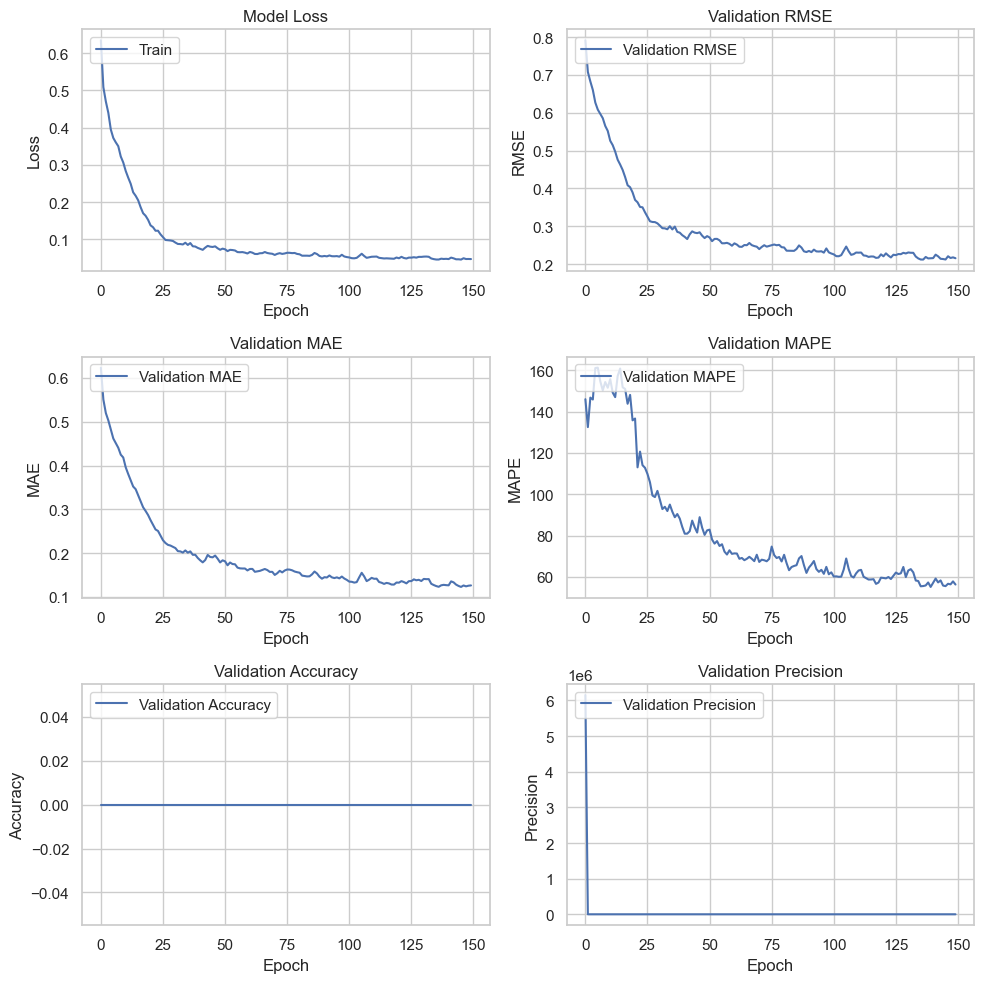

In [12]:
# Extract the metrics from the history
train_loss = history.history['loss']
val_rmse = history.history['rmse']
val_mae = history.history['mean_absolute_error']
val_mape = history.history['mape']
val_accuracy = history.history['accuracy']
val_precision = history.history['precision']

# Plot the performance metrics using seaborn
sns.set(style="whitegrid")

fig, axs = plt.subplots(3, 2, figsize=(10, 10))

# Plot training & validation loss values
sns.lineplot(x=range(len(train_loss)), y=train_loss, ax=axs[0, 0], label='Train')
axs[0, 0].set_title('Model Loss')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].legend(loc='upper left')

# Plot RMSE values
sns.lineplot(x=range(len(val_rmse)), y=val_rmse, ax=axs[0, 1], label='Validation RMSE')
axs[0, 1].set_title('Validation RMSE')
axs[0, 1].set_ylabel('RMSE')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].legend(loc='upper left')

# Plot MAE values
sns.lineplot(x=range(len(val_mae)), y=val_mae, ax=axs[1, 0], label='Validation MAE')
axs[1, 0].set_title('Validation MAE')
axs[1, 0].set_ylabel('MAE')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].legend(loc='upper left')

# Plot MAPE values
sns.lineplot(x=range(len(val_mape)), y=val_mape, ax=axs[1, 1], label='Validation MAPE')
axs[1, 1].set_title('Validation MAPE')
axs[1, 1].set_ylabel('MAPE')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].legend(loc='upper left')

# Plot Accuracy values
sns.lineplot(x=range(len(val_accuracy)), y=val_accuracy, ax=axs[2, 0], label='Validation Accuracy')
axs[2, 0].set_title('Validation Accuracy')
axs[2, 0].set_ylabel('Accuracy')
axs[2, 0].set_xlabel('Epoch')
axs[2, 0].legend(loc='upper left')

# Plot Precision values
sns.lineplot(x=range(len(val_precision)), y=val_precision, ax=axs[2, 1], label='Validation Precision')
axs[2, 1].set_title('Validation Precision')
axs[2, 1].set_ylabel('Precision')
axs[2, 1].set_xlabel('Epoch')
axs[2, 1].legend(loc='upper left')

plt.tight_layout()
plt.show()

In [13]:
# Print the metrics
print("Training Loss: ", train_loss[-1])
print("Validation RMSE: ", val_rmse[-1])
print("Validation MAE: ", val_mae[-1])
print("Validation MAPE: ", val_mape[-1])
print("Validation Precision: ", val_precision[-1])


Training Loss:  0.04688379168510437
Validation RMSE:  0.2156643122434616
Validation MAE:  0.126267671585083
Validation MAPE:  56.32883071899414
Validation Precision:  1.680772066116333


In [14]:
# Prepare the input with the last 8 rows
future_input = data[-time_steps:].reshape(1, time_steps, df.shape[1])

# Directly predict the next 40 rows
future_predictions = model.predict(future_input)  # Shape: (1, 40, 8)

# Remove batch dimension
future_predictions = future_predictions[0]  # Shape: (40, 8)

# Inverse transform back to original scale
future_predictions = scaler.inverse_transform(future_predictions)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


In [15]:
future_years = np.arange(2022, 2027).repeat(8)
future_df = pd.DataFrame(future_predictions, columns=df.columns)
future_df["Year"] = future_years
future_df.to_csv(r"../data_3/RNN.csv", index=False)

In [16]:
model.save(r'../Models/Deploy/RNN.keras')